In [62]:
import sys

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from numpy.linalg import LinAlgError

import ml_utils
from ml_utils import n_image_in_category, plot_sample_for_each_digit, perform_linear_ridge_regression, evaluate_w_opt
import circle_utils

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# try to load the data and present some example images

there are 2000 grayscale images, 200 from each class

15 x 16 = 240 pixels

first 200 rows are 0, next 200 are 1, etc

In [2]:
raw_data = ml_utils.load_data()

In [3]:
raw_data.shape

(2000, 240)

In [4]:
np.random.seed(1)

In [5]:
train_data: np.array
test_data: np.array
train_data, test_data = ml_utils.train_test_split(raw_data)

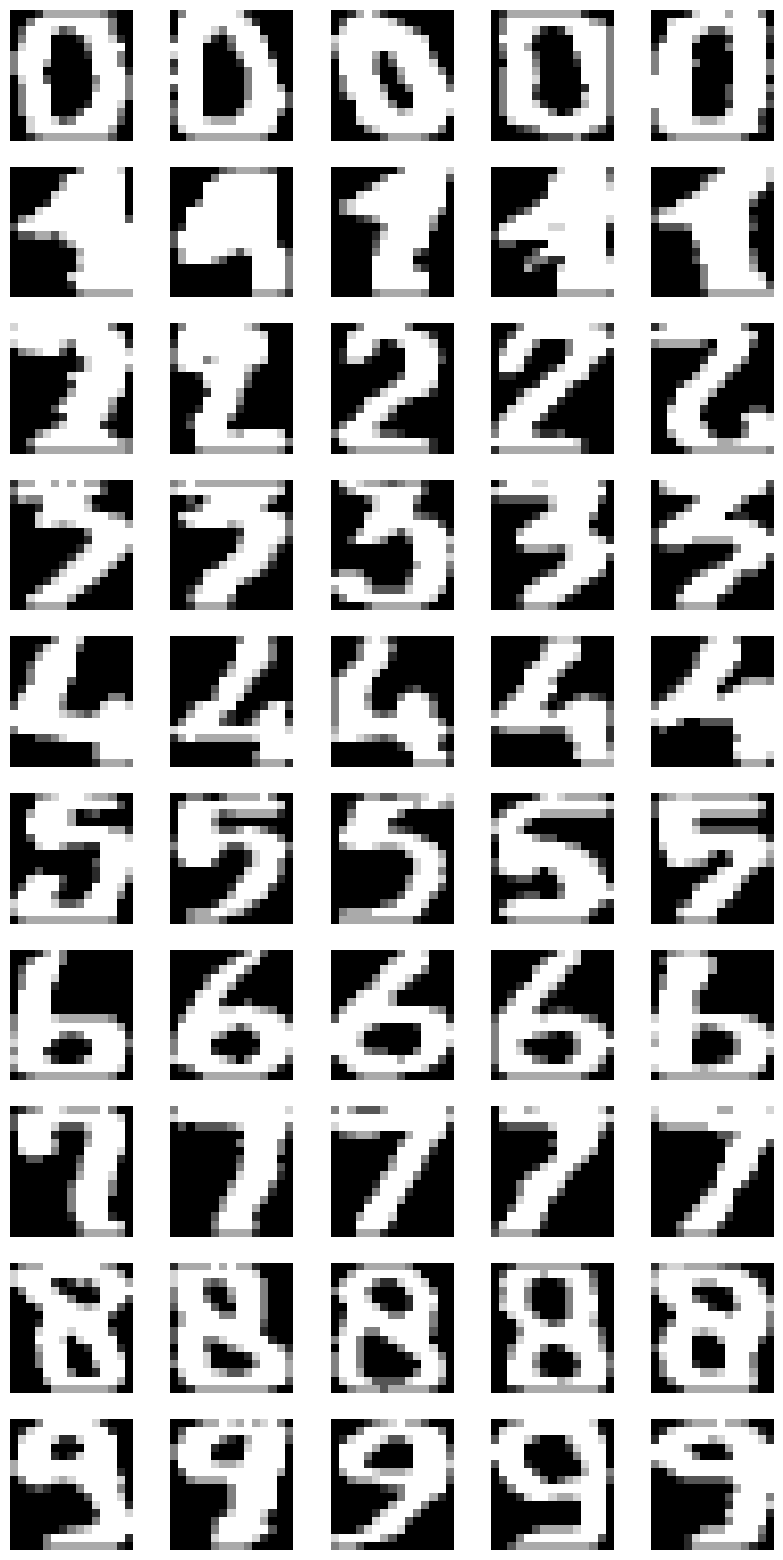

In [6]:
fig = plot_sample_for_each_digit(train_data, 5, (10, 20))
fig.savefig('figures/sample_images.svg', bbox_inches='tight')
# plt.show()

# Linear regression (from the lecture notes)
given a collection of N training data points (xi, yi) where xi in R^n and yi in R
  - we have N = 1000
  - n = 240
  - range of xi is 0-6
  - range of yi is 0-9

Wanted: linear map from R^240 to R, represented by a _regression weight vector_ *w* (a row vector of size n = 240), which solves the minimization problem:
  - *w* = argmin_w sum_i (w \* xi - yi)^2
  - adding a bias to the argmin_w term, we get an affine linear function:
    - *w, b* = argmin_w,b sum_i (w \* xi + b - yi)^2
  - the bias can be added by adding a constant 1 to the end of each xi

Notes continue to explain that the n values of each component of the input vectors create n-dimensional vectors (p1,..., pn) a *?(not sure)* dimensional subspace *_F_* in R^N. The N target values of y also create a N-dimensional vector, our problem is finding a linear combination yopt = w1\*p1+...+wn\*pn that minimizes the distance to the target vector y given by the projection of y on *_F_*.

To solve we might need to understand a bit of linear algebra, but the application might do as well:
Define X = (p1...pn)', a matrix of size n x N which rows are p1,...,pn and columns are xi.
Also define y as a column vector of size N, with the target values yi.
Then we can find w_opt by w' = (XX')^-1 Xy

an optimization called _ridge regression_ is possible here by adding a small multiple of *I* (Identity) before doing the inverse:
 - w' = (XX' + small_value*I)^-1 Xy

#### Now lets try it

Perform linear ridge regression on the raw images
one-hot encode the labels

In [7]:
X = train_data

# one-hot encode the labels
y = ml_utils.one_hot_y(X)

w_opt = perform_linear_ridge_regression(X, y, alpha=0.00)

Test our classifier

In [ ]:
evaluate_w_opt(w_opt, X, test_data, y, y)

In [72]:
def find_best_alpha_for(X_train, Y_train, k_fold_results=None, n_folds=100):
    if k_fold_results is None:
        k_fold_results = []

    def perform_and_evaluate_linear_ridge_regression(train_set, val_set, train_y, val_y, alpha):
        w_opt = perform_linear_ridge_regression(train_set, train_y, alpha=alpha)
        misclassified_train, misclassified_test = evaluate_w_opt(w_opt, train_set, val_set, train_y, val_y,
                                                                 verbose=False)
        return misclassified_train / train_set.shape[0], misclassified_test / val_set.shape[0]

    # test alpha's between 0 and 15
    for alpha in range(150):
        real_alpha = (alpha / 10)
        func = lambda train_set, val_set, train_y, val_y: (
            perform_and_evaluate_linear_ridge_regression(train_set, val_set, train_y, val_y, alpha=real_alpha))

        try:
            k_results = ml_utils.k_fold_analysis(X_train, Y_train, n_folds, func)
        except LinAlgError:
            continue

        k_mean = np.mean(k_results, axis=0)
        k_fold_results.append([real_alpha, *k_mean])

    k_fold_results = np.array(k_fold_results)
    best_alpha_index = np.argmin(k_fold_results[:, 2])
    best_alpha = k_fold_results[best_alpha_index][0]
    return k_fold_results, best_alpha


def plot_k_fold_alpha_results(k_fold_results, best_alpha, plot_name):
    df = pd.DataFrame(k_fold_results, columns=['alpha', 'train', 'validation'])

    df = pd.melt(df, 'alpha')
    fig = plt.figure()
    sns.lineplot(data=df, x='alpha', y='value', hue='variable')
    plt.xlabel("alpha")
    plt.ylabel("misclassification rate")

    plt.axvline(x=best_alpha, ls='--', c='red', lw=.5)

    plt.show()
    fig.savefig(f'figures/{plot_name}.svg', bbox_inches='tight')

In [73]:
k_fold_results, best_alpha = find_best_alpha_for(X, y)

8.1


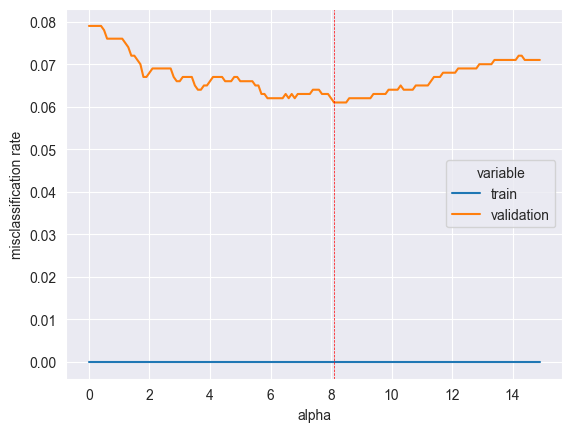

In [74]:
print(best_alpha)
plot_k_fold_alpha_results(k_fold_results, best_alpha, 'k_fold_alpha')

In [75]:
w_opt = perform_linear_ridge_regression(X, y, alpha=best_alpha)
evaluate_w_opt(w_opt, X, test_data, y, y)

train: misclassified: 39, misclassification rate: 3.9%
test: misclassified: 68, misclassification rate: 6.8%


(39, 68)

### now with circles

6.1


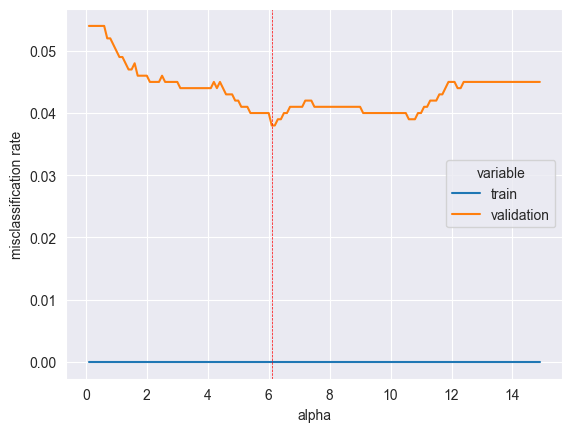

In [76]:
X_train = np.concatenate([train_data, circle_utils.get_circle_data_as_feature(train_data)], axis=1)
X_test = np.concatenate([test_data, circle_utils.get_circle_data_as_feature(test_data)], axis=1)

k_fold_results, best_alpha = find_best_alpha_for(X_train, y)
print(best_alpha)
plot_k_fold_alpha_results(k_fold_results, best_alpha, 'k_fold_alpha_circles')

In [78]:
w_opt = ml_utils.perform_linear_ridge_regression(X_train, y, alpha=best_alpha)
ml_utils.evaluate_w_opt(w_opt, X_train, X_test, y, y)

train: misclassified: 23, misclassification rate: 2.3%
test: misclassified: 45, misclassification rate: 4.5%


(23, 45)

Compare to random

In [79]:
random_results = []
for _ in range(X.shape[0]):
    misclassified_random = 0
    choices = np.random.random(test_data.shape[0]) * 9
    for i in range(test_data.shape[0]):
        if round(choices[i]) != np.argmax(y[i]):
            misclassified_random += 1
    random_results.append(misclassified_random / test_data.shape[0])
random_results = np.array(random_results)

Random Misclassification Rate -- mean: 90.02%, min: 85.90%, max: 92.30%


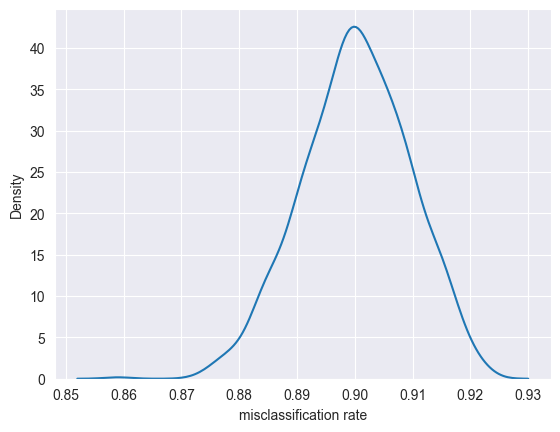

In [80]:
sns.kdeplot(random_results)
plt.xlabel("misclassification rate")
print(
    f"Random Misclassification Rate -- mean: {np.mean(random_results) * 100:.2f}%, min: {np.min(random_results) * 100:.2f}%, max: {np.max(random_results) * 100:.2f}%")

# Results ??

### using prototype vectors based on class means (from the lecture notes)

calculate class means and do a vector multiplication with each training image for each class

resulting in 10 features for each training image describing 'similarity' to the class mean

In [81]:
prototypes = []
n_images = n_image_in_category(train_data)
for i in range(10):
    start_index = i * n_images
    prototypes.append(np.mean(train_data[start_index:start_index + n_images], axis=0))
prototypes = np.array(prototypes)
prototypes.shape

(10, 240)

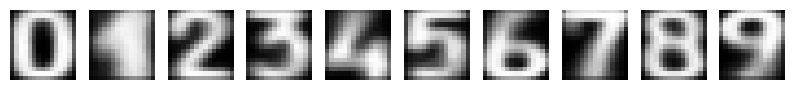

In [82]:
# plot all class means
fig = plot_sample_for_each_digit(prototypes, 1, (10, 1), horizontal=True)
fig.savefig('figures/prototypes.svg', bbox_inches='tight')

In [83]:
print(f'digit | sum | px>0.5 | avg')
for digit, prototype in enumerate(prototypes):
    # print(f'  {digit}   | {round(prototype.sum())} |   {(prototype > 0.5).sum()}  | {round(prototype.sum() / 240, 2)}')
    print(
        f'  {digit}   & {round(prototype.sum())} &   {(prototype > 0.5).sum()}  & {round(prototype.sum() / 240, 2):<04} \\\\')
print((prototypes.sum(axis=1) / 240).min())
print((prototypes.sum(axis=1) / 240).max())

digit | sum | px>0.5 | avg
  0   & 135 &   141  & 0.56 \\
  1   & 132 &   140  & 0.55 \\
  2   & 114 &   117  & 0.48 \\
  3   & 117 &   119  & 0.49 \\
  4   & 107 &   106  & 0.45 \\
  5   & 124 &   127  & 0.52 \\
  6   & 119 &   122  & 0.50 \\
  7   & 103 &   101  & 0.43 \\
  8   & 136 &   145  & 0.56 \\
  9   & 121 &   125  & 0.50 \\
0.430013888888889
0.5649027777777778


In [84]:
# multiply training images with class means
avg_feature_values_train = train_data @ prototypes.T
avg_feature_values_test = test_data @ prototypes.T
avg_feature_values_train.shape

(1000, 10)

now we have reduced X from 240 features to 10

try ridge regression again

In [145]:
w_opt = perform_linear_ridge_regression(avg_feature_values_train, y)

In [146]:
evaluate_w_opt(w_opt, avg_feature_values_train, avg_feature_values_test, y, y)

train: misclassified: 72, misclassification rate: 7.2%
test: misclassified: 81, misclassification rate: 8.1%


(72, 81)

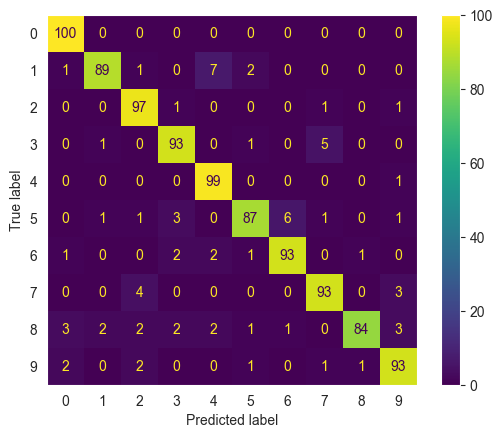

In [124]:
predicted_y = []
real_y = []
for i in range(10):
    for j in range(100):
        prediction = ml_utils.make_prediction(w_opt, avg_feature_values_train[i*100+j])
        predicted_y.append(np.argmax(prediction))
        real_y.append(i)
conf_matrix = confusion_matrix(real_y, predicted_y)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp = disp.plot()
plt.grid(False)
disp.figure_.savefig('figures/confmatrix_prototypes.svg', bbox_inches='tight')

# Next we use K-fold cross validation to find the optimal number of principal components 

In [87]:
k_fold_pca_alpha = 0
k_fold_misclassifications = []
n_folds = 50
max_n_components = 240

# cache pca and select n_components later
pca = PCA(max_n_components, svd_solver='full').fit(train_data)

for n_components in range(max_n_components):
    func = lambda train_set, val_set, train_y, val_y: ml_utils.pca_ridge_regression(
        train_set, val_set, train_y, val_y, alpha=k_fold_pca_alpha, n_components=n_components + 1, use_pca=pca)

    k_fold_results = ml_utils.k_fold_analysis(train_data, y, n_folds, func)

    k_fold_misclassifications.append(np.mean(k_fold_results, axis=0))
k_fold_misclassifications = np.array(k_fold_misclassifications)

In [88]:
df = pd.DataFrame(k_fold_misclassifications, columns=['train', 'validation'])
df.insert(0, 'principal components', np.arange(max_n_components) + 1)
df = pd.melt(df, 'principal components')
df.head()

,principal components,variable,value
0,1,train,1.000
1,2,train,0.049
2,3,train,0.049
3,4,train,0.049
4,5,train,0.049


In [89]:
best_train_result = np.min(k_fold_misclassifications[:, 0])
best_train_n_components = np.argmin(k_fold_misclassifications[:, 0]) + 1
best_val_result = np.min(k_fold_misclassifications[:, 1])
best_val_n_components = np.argmin(k_fold_misclassifications[:, 1]) + 1
best_val_n_components

32

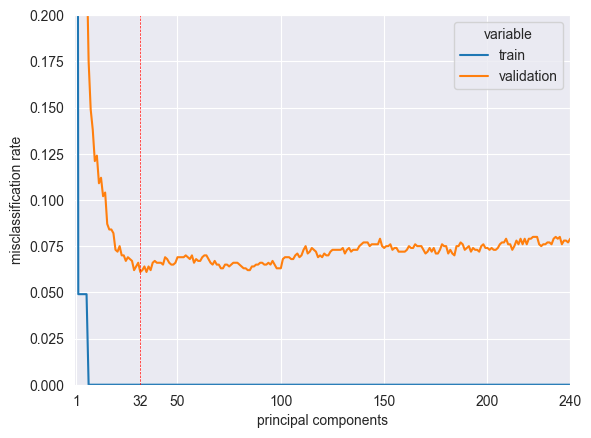

In [90]:
from matplotlib.lines import Line2D

fig = plt.figure()
sns.lineplot(data=df, x='principal components', y='value', hue='variable')
plt.xlabel("principal components")
plt.ylabel("misclassification rate")

plt.ylim(0, 0.2)

plt.axvline(x=best_val_n_components, ls='--', c='red', lw=.5)
plt.xlim(0, max_n_components)
plt.xticks([1, best_val_n_components, 50, 100, 150, 200, 240])

plt.show()
fig.savefig('figures/pca_analysis.svg', bbox_inches='tight')

In [91]:
print(
    f"best train result of PCA: {best_train_result * 100:.1f}% for {best_train_n_components} components")
print(
    f"best val  result of PCA: {best_val_result * 100:.1f}% for {best_val_n_components} components")

print("there might be multiple minimum values:")
np.where(k_fold_misclassifications[:, 1] == k_fold_misclassifications[:, 1].min())

best train result of PCA: 0.0% for 7 components
best val  result of PCA: 6.1% for 32 components
there might be multiple minimum values:


(array([31]),)

### Use the results of the PCA to select n_components for training a final classifier and evaluate it on the Test set

In [109]:
pca = PCA(n_components=best_val_n_components, svd_solver='full')
fitted = pca.fit(train_data)
train_pca = fitted.transform(train_data)
test_pca = fitted.transform(test_data)

w_opt = perform_linear_ridge_regression(train_pca, y, alpha=k_fold_pca_alpha)
# arrays of correct and misclassified 'confidences'
confidences = [[], []]
# array of misclassified images
misclassified_images = []
# array of corresponding (real_y, predicted_y) tuples
misclassified_image_y = []

predicted_labels = []
true_labels = []
for i in range(y.shape[0]):
    img = test_pca[i]
    prediction = ml_utils.make_prediction(w_opt, img)
    predicted_y = np.argmax(prediction)
    confidence = prediction[predicted_y]
    real_y = np.argmax(y[i])
    predicted_labels.append(predicted_y)
    true_labels.append(real_y)
    if predicted_y == real_y:
        confidences[0].append(confidence)
    else:
        confidences[1].append(confidence)
        misclassified_images.append(img)
        misclassified_image_y.append((real_y, predicted_y))
misclassified_image_y = np.array(misclassified_image_y)
misclassified_images = pca.inverse_transform(misclassified_images)

In [110]:
evaluate_w_opt(w_opt, train_pca, test_pca, y, y)

train: misclassified: 51, misclassification rate: 5.1%
test: misclassified: 62, misclassification rate: 6.2%


(51, 62)

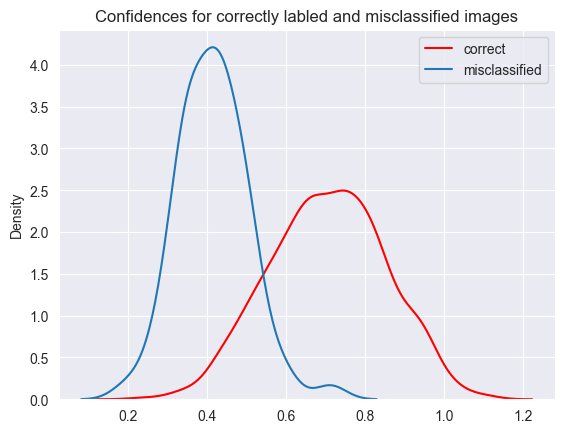

In [111]:
sns.kdeplot(confidences[0], color='r')
sns.kdeplot(confidences[1])
plt.legend(labels=['correct', 'misclassified'])
plt.title('Confidences for correctly labled and misclassified images')
plt.show()

plot all misclassified images after PCA reconstruction

note: is this ok? we get input from the test set here

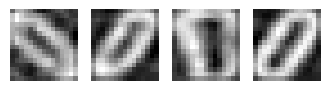

4        4        9        6


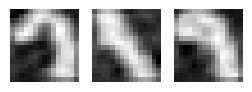

9        4        9


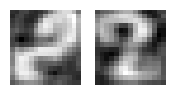

6        7


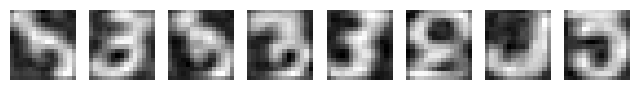

4        9        4        2        6        9        6        0


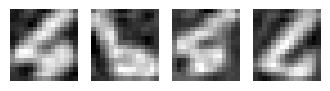

1        6        1        1


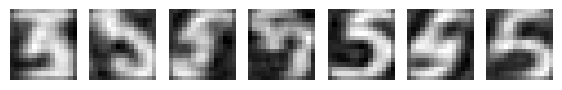

3        4        6        9        3        6        4


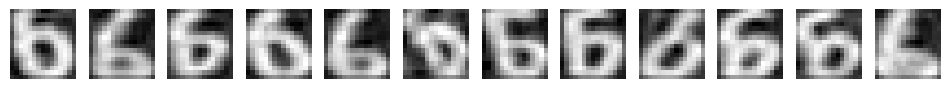

5        4        5        5        4        1        5        5        3        5        5        4


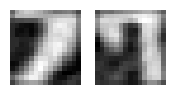

3        9


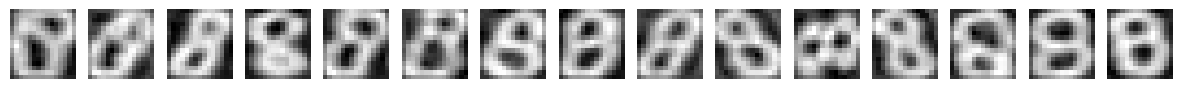

5        1        1        9        5        5        6        0        9        2        1        9        0        6        0


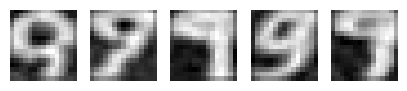

0        7        1        1        7


In [112]:
misclassified_per_class = [[] for _ in range(10)]
misclassified_per_class_y = [[] for _ in range(10)]
current_class = -1

for i in range(misclassified_image_y.shape[0]):
    real_y = misclassified_image_y[i, 0]
    if real_y != current_class:
        current_class = real_y
    misclassified_per_class[current_class].append(misclassified_images[i])
    misclassified_per_class_y[current_class].append(misclassified_image_y[i])

for k, images in enumerate(misclassified_per_class):
    img_in_class = len(images)
    if img_in_class > 0:
        figure = plt.figure(figsize=(img_in_class, 1))
        for i, img in enumerate(images):
            figure.add_subplot(1, img_in_class, i + 1)

            img = img.reshape(16, 15)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.show()
        predictions = [str(i[1]) for i in misclassified_per_class_y[k]]
        print('        '.join(predictions))


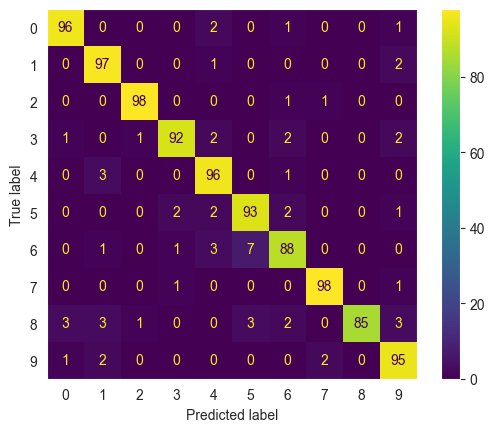

In [113]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp = disp.plot()
plt.grid(False)
disp.figure_.savefig('figures/confmatrix_pca.svg', bbox_inches='tight')

# circle madness

add one-hot-encoded circle features to the data
either before doing PCA (no performance increase)
or add the features to the principal components (go from 6% to 3.4% misclassifications) 

In [120]:
pca = PCA(n_components=best_val_n_components, svd_solver='full')

fitted = pca.fit(train_data)
train_pca = fitted.transform(train_data)
test_pca = fitted.transform(test_data)

# add circle features to principle components
train_pca = np.concatenate([train_pca, circle_utils.get_circle_data_as_feature(train_data)], axis=1)
test_pca = np.concatenate([test_pca, circle_utils.get_circle_data_as_feature(test_data)], axis=1)

w_opt = perform_linear_ridge_regression(train_pca, y, alpha=0.01)
# arrays of correct and misclassified 'confidences'
confidences = [[], []]
# array of misclassified images
misclassified_images = []
# array of corresponding (real_y, predicted_y) tuples
misclassified_image_y = []

predicted_labels = []
true_labels = []
for i in range(y.shape[0]):
    img = test_pca[i]
    prediction = ml_utils.make_prediction(w_opt, img)
    predicted_y = np.argmax(prediction)
    confidence = prediction[predicted_y]
    real_y = np.argmax(y[i])
    predicted_labels.append(predicted_y)
    true_labels.append(real_y)
    if predicted_y == real_y:
        confidences[0].append(confidence)
    else:
        confidences[1].append(confidence)
        # remove circle indicators from image
        misclassified_images.append(img[:-5])

        misclassified_image_y.append((real_y, predicted_y))
misclassified_image_y = np.array(misclassified_image_y)
misclassified_images = pca.inverse_transform(misclassified_images)
evaluate_w_opt(w_opt, train_pca, test_pca, y, y)

train: misclassified: 31, misclassification rate: 3.1%
test: misclassified: 35, misclassification rate: 3.5%


(31, 35)

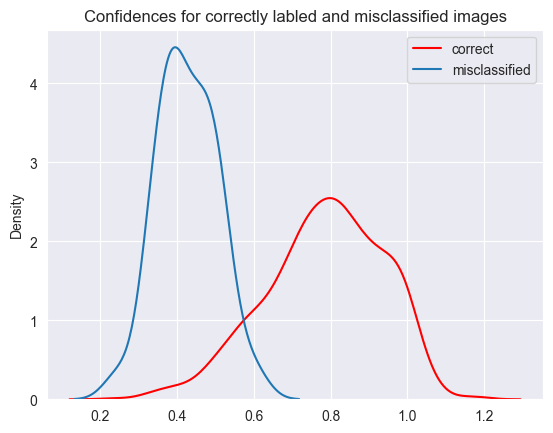

In [106]:
sns.kdeplot(confidences[0], color='r')
sns.kdeplot(confidences[1])
plt.legend(labels=['correct', 'misclassified'])
plt.title('Confidences for correctly labled and misclassified images')
plt.show()

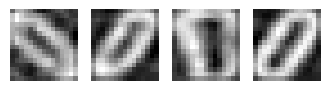

9        9        5        6


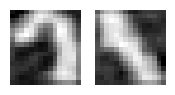

4        4


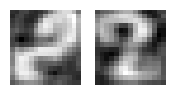

6        7


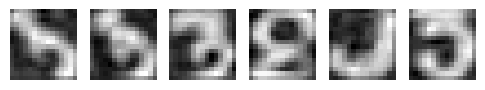

4        9        2        5        4        0


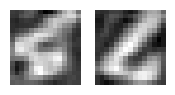

1        1


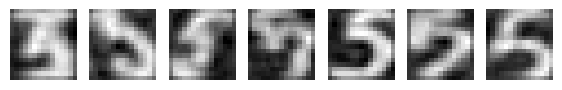

3        4        2        9        3        0        4


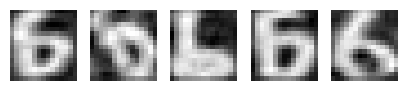

9        9        4        5        5


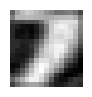

3


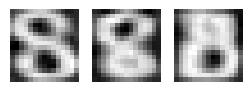

9        9        0


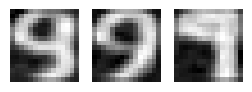

1        5        1


In [107]:
misclassified_per_class = [[] for _ in range(10)]
misclassified_per_class_y = [[] for _ in range(10)]
current_class = -1

for i in range(misclassified_image_y.shape[0]):
    real_y = misclassified_image_y[i, 0]
    if real_y != current_class:
        current_class = real_y
    misclassified_per_class[current_class].append(misclassified_images[i])
    misclassified_per_class_y[current_class].append(misclassified_image_y[i])

for k, images in enumerate(misclassified_per_class):
    img_in_class = len(images)
    if img_in_class > 0:
        figure = plt.figure(figsize=(img_in_class, 1))
        for i, img in enumerate(images):
            figure.add_subplot(1, img_in_class, i + 1)

            img = img.reshape(16, 15)

            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.show()
        predictions = [str(i[1]) for i in misclassified_per_class_y[k]]
        print('        '.join(predictions))

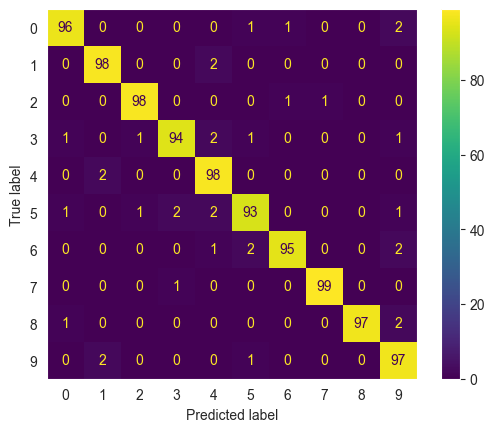

In [108]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp = disp.plot()
plt.grid(False)
disp.figure_.savefig('figures/confmatrix_pca_circles.svg', bbox_inches='tight')

# putting it all together

In [100]:
train_data.shape

(1000, 240)

In [101]:
pca = PCA(n_components=best_val_n_components, svd_solver='full')

fitted = pca.fit(train_data)
train_pca = fitted.transform(train_data)
test_pca = fitted.transform(test_data)

# add circle features to principle components
train_pca = np.concatenate([train_pca, circle_utils.get_circle_data_as_feature(train_data)], axis=1)
test_pca = np.concatenate([test_pca, circle_utils.get_circle_data_as_feature(test_data)], axis=1)

# add prototype features
train_pca = np.concatenate([train_pca, avg_feature_values_train], axis=1)
test_pca = np.concatenate([test_pca, avg_feature_values_test], axis=1)

w_opt = perform_linear_ridge_regression(train_pca, y)
# arrays of correct and misclassified 'confidences'
confidences = [[], []]
# array of misclassified images
misclassified_images = []
# array of corresponding (real_y, predicted_y) tuples
misclassified_image_y = []
for i in range(y.shape[0]):
    img = test_pca[i]
    prediction = ml_utils.make_prediction(w_opt, img)
    predicted_y = np.argmax(prediction)
    confidence = prediction[predicted_y]
    real_y = np.argmax(y[i])
    if predicted_y == real_y:
        confidences[0].append(confidence)
    else:
        confidences[1].append(confidence)
        # remove circle indicators from image
        misclassified_images.append(img[:-15])

        misclassified_image_y.append((real_y, predicted_y))
misclassified_image_y = np.array(misclassified_image_y)
misclassified_images = pca.inverse_transform(misclassified_images)
evaluate_w_opt(w_opt, train_pca, test_pca, y, y)

train: misclassified: 22, misclassification rate: 2.2%
test: misclassified: 43, misclassification rate: 4.3%


(22, 43)

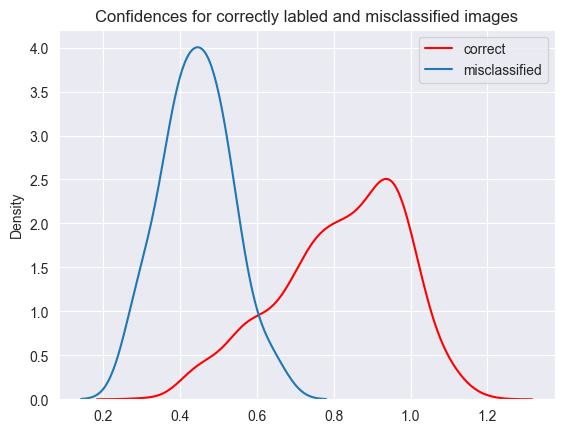

In [102]:
sns.kdeplot(confidences[0], color='r')
sns.kdeplot(confidences[1])
plt.legend(labels=['correct', 'misclassified'])
plt.title('Confidences for correctly labled and misclassified images')
plt.show()